Here is the readme for this dataset: http://sentinel-1-global-coherence-earthbigdata.s3-website-us-west-2.amazonaws.com/#Global_Tiles

There are also information about the dataset here: https://aws.amazon.com/marketplace/pp/prodview-iz6lnjbdlgcwa#usage including sample notebooks

In [1]:
import boto3
import geopandas as gpd
from rasterio.crs import CRS
from shapely.geometry import box
import rasterio
from tqdm import tqdm
import concurrent.futures
import json
import matplotlib.pyplot as plt
from rasterio.plot import show
from shapely.geometry import Polygon

# Read bucket

In [2]:
s3 = boto3.resource('s3')
s1_coh_bucket = s3.Bucket('sentinel-1-global-coherence-earthbigdata')

In [3]:
objects_all = s1_coh_bucket.objects

In [4]:
tif_tiles = s1_coh_bucket.objects.filter(Prefix='data/tiles/N').all()

In [5]:
%%time

coh_12_day_objs = [obj for obj in tif_tiles if obj.key[-10:] == '_COH12.tif']
len(coh_12_day_objs)

In [6]:
coh_12d_data = [{'bucket': obj.bucket_name, 'key': obj.key} for obj in coh_12_day_objs]

In [7]:
json.dump(coh_12d_data, open('coh_s3_data.json', 'w'))

# Load and Inspect

In [2]:
coh_s3_data = json.load(open('coh_s3_data.json'))

In [3]:
data = coh_s3_data[60488]#coh_s3_data[-10_000]
bucket = data['bucket']
key = data['key']
with rasterio.open(f's3://{bucket}/{key}') as ds:
    X = ds.read(1)
    p = ds.profile
data, p

({'bucket': 'sentinel-1-global-coherence-earthbigdata',
  'key': 'data/tiles/N71E028_fall_vv_COH12.tif'},
 {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 1200, 'height': 1200, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00083333333, 0.0, 28.0,
        0.0, -0.00083333333, 71.0), 'blockysize': 6, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'})

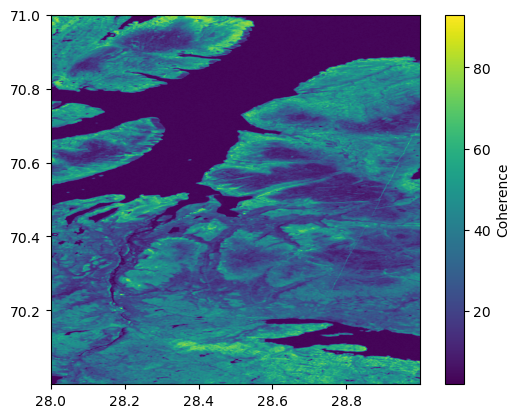

In [4]:
fig, ax=plt.subplots()
out = show(X, transform=p['transform'], ax=ax)
im = out.get_images()[0]

fig.colorbar(im, label='Coherence')

# Create GeoJSON

In [7]:
def get_bounds_from_tile_id(tile_id: str) -> tuple[float]:
    lat_str = tile_id[:3]
    lon_str = tile_id[3:]
    lat = float(tile_id[1:3])
    lon = float(tile_id[4:])
    if 'S' in lat_str:
        lat = -lat
    if 'W' in lon_str:
        lon = -lon
    return lon, lat - 1, lon + 1, lat
    
def get_geometry_from_s3_data(data: dict) -> Polygon:
    key = data['key']
    tile_id = key.split('/')[-2]
    if len(tile_id) != 7:
        return Polygon()
    bounds = get_bounds_from_tile_id(tile_id)        
    return box(*bounds)

def build_url_and_update(data: dict) -> str:
    bucket = data['bucket']
    key = data['key']
    url = f'https://{bucket}.s3.us-west-2.amazonaws.com/{key}'
    data['url'] = url
    return data

In [8]:
coh_s3_data = list(map(build_url_and_update, coh_s3_data))
coh_s3_data[0]

{'bucket': 'sentinel-1-global-coherence-earthbigdata',
 'key': 'data/tiles/N00E005/N00E005_fall_vv_COH12.tif',
 'url': 'https://sentinel-1-global-coherence-earthbigdata.s3.us-west-2.amazonaws.com/data/tiles/N00E005/N00E005_fall_vv_COH12.tif'}

In [9]:
geometry = list(map(get_geometry_from_s3_data, tqdm(coh_s3_data)))

100%|█████| 70004/70004 [00:00<00:00, 113436.82it/s]


In [10]:
df = gpd.GeoDataFrame(coh_s3_data, geometry=geometry, crs=CRS.from_epsg(4326))

<Axes: >

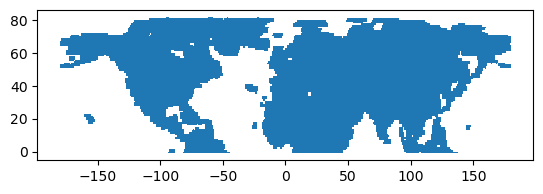

In [11]:
df.plot()

In [12]:
empty_ind = df.geometry.map(lambda geo: geo.is_empty)
empty_ind.sum()

4

In [13]:
df = df[~empty_ind].reset_index(drop=True)

# Remaining Metadata

In [14]:
df['tile_id'] = df.key.map(lambda key: key.split('/')[-2])
df['season'] = df.key.map(lambda key: key.split('/')[-1].split('_')[1])
df['season'].unique()

array(['fall', 'spring', 'summer', 'winter'], dtype=object)

In [15]:
df.head()

,bucket,key,url,geometry,tile_id,season
0,sentinel-1-global-coherence-earthbigdata,data/tiles/N00E005/N00E005_fall_vv_COH12.tif,https://sentinel-1-global-coherence-earthbigda...,"POLYGON ((6.00000 -1.00000, 6.00000 0.00000, 5...",N00E005,fall
1,sentinel-1-global-coherence-earthbigdata,data/tiles/N00E005/N00E005_spring_vv_COH12.tif,https://sentinel-1-global-coherence-earthbigda...,"POLYGON ((6.00000 -1.00000, 6.00000 0.00000, 5...",N00E005,spring
2,sentinel-1-global-coherence-earthbigdata,data/tiles/N00E005/N00E005_summer_vv_COH12.tif,https://sentinel-1-global-coherence-earthbigda...,"POLYGON ((6.00000 -1.00000, 6.00000 0.00000, 5...",N00E005,summer
3,sentinel-1-global-coherence-earthbigdata,data/tiles/N00E005/N00E005_winter_vv_COH12.tif,https://sentinel-1-global-coherence-earthbigda...,"POLYGON ((6.00000 -1.00000, 6.00000 0.00000, 5...",N00E005,winter
4,sentinel-1-global-coherence-earthbigdata,data/tiles/N00E006/N00E006_fall_vv_COH12.tif,https://sentinel-1-global-coherence-earthbigda...,"POLYGON ((7.00000 -1.00000, 7.00000 0.00000, 6...",N00E006,fall


# Serialize

In [16]:
df.to_file('coherence_tiles.geojson', driver='GeoJSON')